In [107]:
%load_ext autoreload
%autoreload 2

import importlib
import numpy as np
import pandas as pd
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from stocks import Stocks
from agents.agent import Agent
from utils import *
from visualizations import *

Using TensorFlow backend.


In [161]:
df = pd.DataFrame([{'A': 100, 'B': 50, 'C': 20, 'D': 1}, {'A': 150, 'B': 100, 'C': 10, 'D': 1}, {'A': 100, 'B': 50, 'C': 20, 'D': 1}])
df

,A,B,C,D
0,100,50,20,1
1,150,100,10,1
2,100,50,20,1


In [162]:
sr = simple_returns(df)
sr

,A,B,C,D
0,0.000000,0.0,0.0,0.0
1,0.500000,1.0,-0.5,0.0
2,-0.333333,-0.5,1.0,0.0


In [164]:
lr = log_returns(df)
lr

,A,B,C,D
0,0.000000,0.000000,0.000000,0.0
1,0.405465,0.693147,-0.693147,0.0
2,-0.405465,-0.693147,0.693147,0.0


In [167]:
cr = cum_returns(sr) + 1
cr

,A,B,C,D
0,1.0,1.0,1.0,1.0
1,1.5,2.0,0.5,1.0
2,1.0,1.0,1.0,1.0


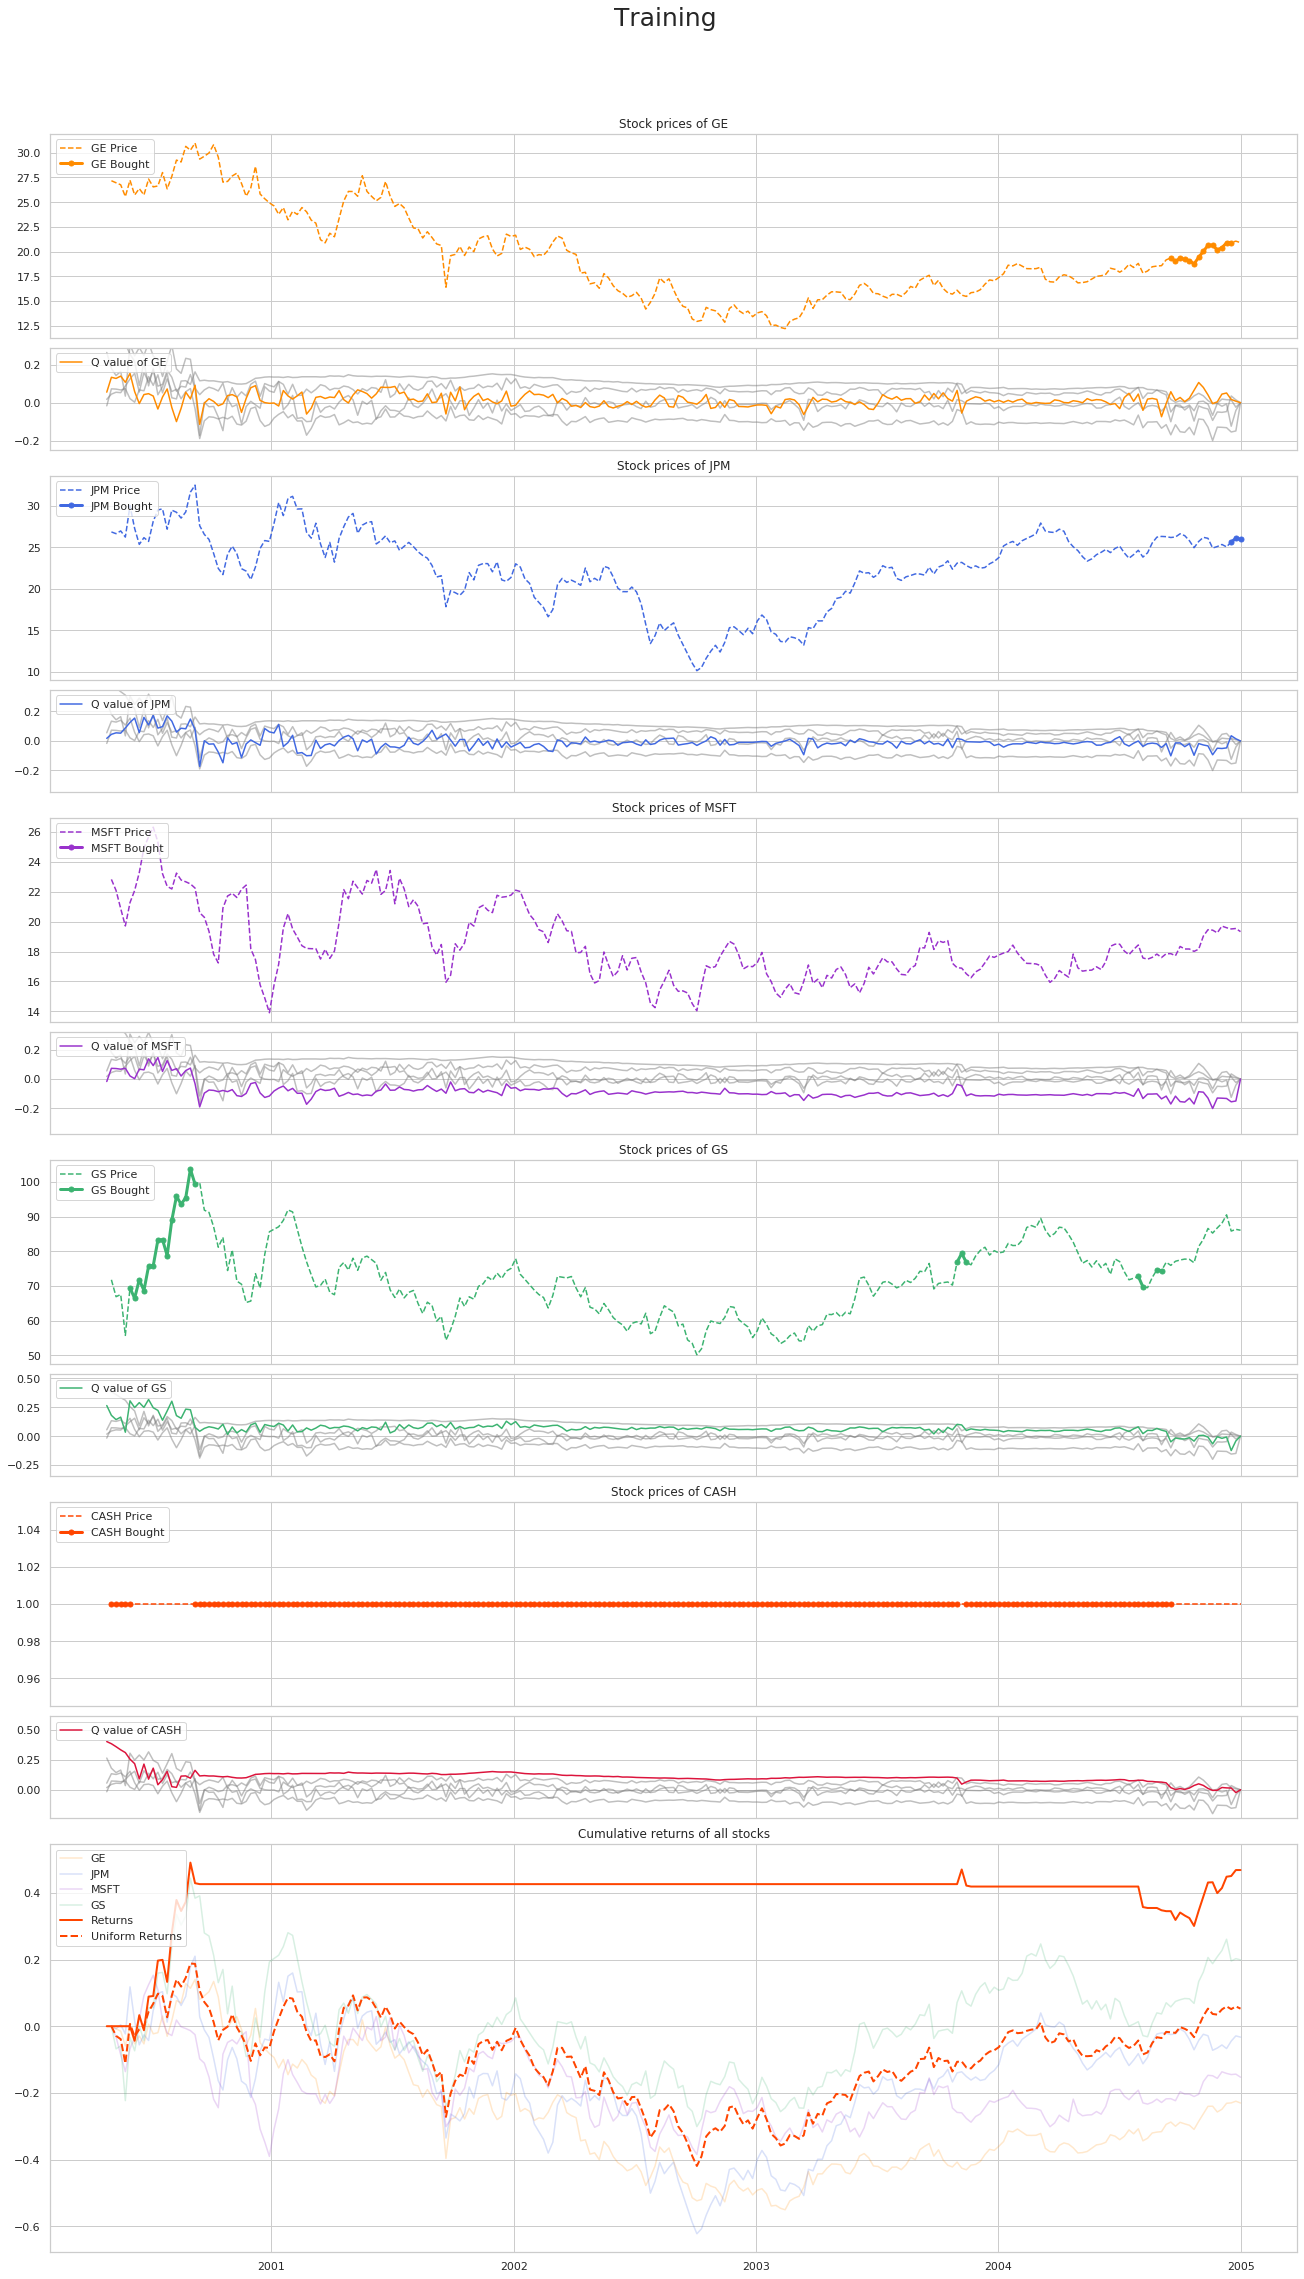

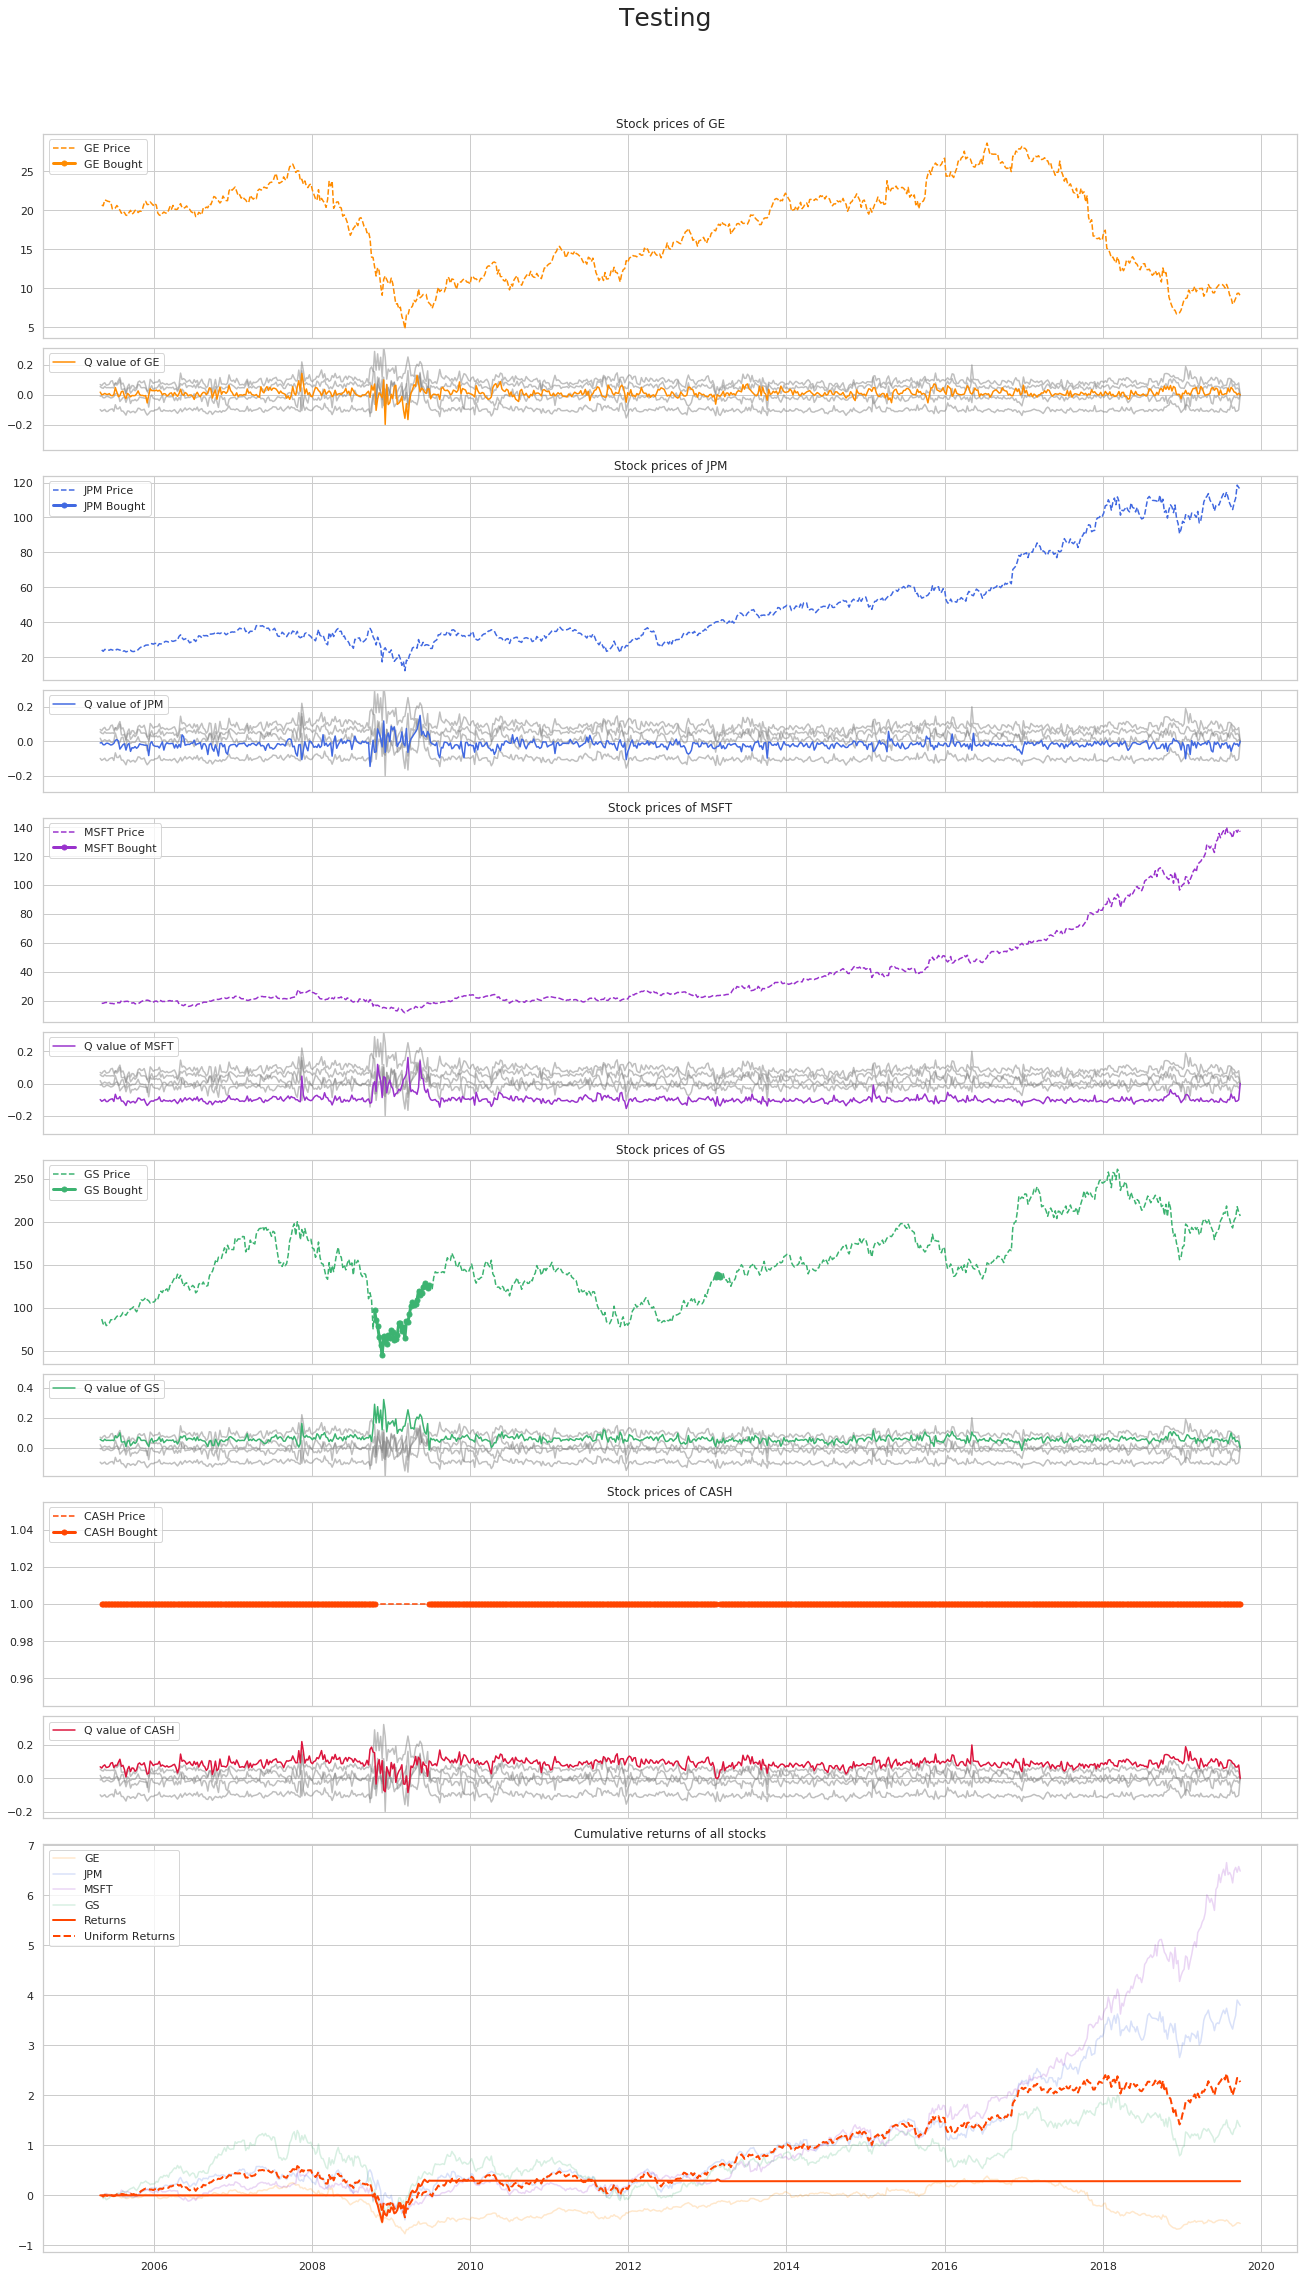

In [191]:
def plot_stocks(episode, mode):
    positions, rewards, returns, q_values = Agent.load_logs(episode, mode)

    dates = positions[np.sum(positions, 1) != 0].index
    tickers = positions.columns[:-1]

    start = dates[0].strftime("%Y-%m-%d")
    end = dates[-1].strftime("%Y-%m-%d")

    # Get the baseline stocks
    baseline = Stocks(tickers, start=start, end=end)

    stocks = positions.columns

    colors = ['darkorange', 'royalblue', 'darkorchid', 'mediumseagreen', 'orangered']

    positions[positions == 0] = np.nan
    positions = positions.bfill(limit=1)
    
    baseline.prices['CASH'] = 1
    
    held = (baseline.prices * positions)

    fig, axis = plt.subplots(len(stocks)*2 + 1, 1, 
                             figsize=(18, len(stocks)*6), 
                             gridspec_kw={'height_ratios': [*[2,1] * len(stocks), 4]},
                             sharex=True,
                             constrained_layout=True)
    
    # Cumulative returns plot
    cum_plot = axis[-1]
    cum_plot.set_title('Cumulative returns of all stocks')

    # Plot individual stocks
    for index, stock in enumerate(stocks):
        stock_plot = axis[index*2]
        value_plot = axis[index*2+1]

        # Color of the stock
        color = colors[index]

        if stock == 'CASH':
            color = 'crimson'

        # Add the cash stock
        baseline.prices['CASH'] = 1
        stock_plot.plot(baseline.prices[stock], color=colors[index], linestyle='dashed')
        stock_plot.plot(held[stock], linewidth=3, color=colors[index], marker='o', markersize=5)
        stock_plot.legend([f'{stock} Price', f'{stock} Bought'], loc='upper left')
        stock_plot.set_title(f'Stock prices of {stock}')

        # background Q values
        for q_value_index, q_value_stock in enumerate(stocks):
            if q_value_stock is not stock:
                value_plot.plot(q_values[q_value_stock], 
                                color='gray',
                                alpha=0.5)

        # Plot actual Q value
        value_plot.plot(q_values[stock], 
                        color=color,
                        label=f'Q value of {stock}')

        min_q = q_values[stock].min()
        max_q = q_values[stock].max()
        q_margin = (max_q - min_q) / 2

        value_plot.legend(loc='upper left')
        value_plot.set_ylim(min_q - q_margin, max_q + q_margin)
#         plt.setp(value_plot.get_yticklabels(), visible=False)
        
        # Add to cumulative plot
        if stock != 'CASH':
            cum_plot.plot(cum_returns(simple_returns(baseline.prices[stock])), 
                          color=colors[index],
                          label=stock,
                          alpha=0.2)

    cum_plot.plot(cum_returns(returns), 
                  linewidth=2, 
                  label='Returns',
                  color='orangered')
    
    no_cash = baseline.prices.iloc[:,:-1]

    cum_plot.plot(cum_returns(np.sum(simple_returns(no_cash) * 1 / no_cash.shape[1], 1)), 
                  linewidth=2,
                  linestyle='--',
                  label='Uniform Returns',
                  color='orangered')
    
    cum_plot.legend(loc='upper left')
    
    fig.suptitle(mode.capitalize(), fontsize=25, x=.51, y=1.05)
    plt.plot()
            
EPISODE = 1300
        
plot_stocks(EPISODE, 'training')
plot_stocks(EPISODE, 'testing')